# Background

In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import types
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# number of universities to fetch
n = 200
tu_link = "https://www.topuniversities.com"

# 1. Obtain the 200 top-ranking universities in www.topuniversities.com

TODO: Describe how json file was found

In [3]:
req_tu_ranking = requests.get(tu_link+'/sites/default/files/qs-rankings-data/357051.txt?_=1508168782318')
tu_ranking = req_tu_ranking.json()["data"]
tu_ranking

[{'cc': 'US',
  'core_id': '410',
  'country': 'United States',
  'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
  'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
  'nid': '294850',
  'rank_display': '1',
  'region': 'North America',
  'score': '100',
  'stars': '6',
  'title': 'Massachusetts Institute of Technology (MIT)',
  'url': '/universities/massachusetts-institute-technology-mit'},
 {'cc': 'US',
  'core_id': '573',
  'country': 'United States',
  'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
  'logo': '<img src="https://www.topuniversities.com/sites/default/files/stanford-university_573_small_0.jpg" alt="Stanford University Logo">',
  'nid': '297282',
  'rank_display': '2',
  'region': 

In [4]:
len(tu_ranking)

959

In [5]:
ranks = []
for i in range(n):
    ranks.append(tu_ranking[i]["rank_display"])
ranks

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '=21',
 '=21',
 '=23',
 '=23',
 '25',
 '26',
 '27',
 '=28',
 '=28',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '=36',
 '=36',
 '=38',
 '=38',
 '40',
 '=41',
 '=41',
 '43',
 '44',
 '45',
 '46',
 '=47',
 '=47',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '=71',
 '=71',
 '=73',
 '=73',
 '75',
 '=76',
 '=76',
 '=78',
 '=78',
 '80',
 '81',
 '=82',
 '=82',
 '=84',
 '=84',
 '86',
 '87',
 '88',
 '89',
 '=90',
 '=90',
 '92',
 '=93',
 '=93',
 '=95',
 '=95',
 '97',
 '=98',
 '=98',
 '100',
 '101',
 '=102',
 '=102',
 '104',
 '105',
 '106',
 '107',
 '108',
 '=109',
 '=109',
 '=109',
 '112',
 '113',
 '=114',
 '=114',
 '=116',
 '=116',
 '118',
 '119',
 '120',
 '121',
 '=122',
 '=122',
 '124',
 '=125',
 '=125',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133

In [6]:
# check equal ranks
print (tu_ranking[20])
print (tu_ranking[21])

# equal scores

{'nid': '294490', 'url': '/universities/duke-university', 'title': 'Duke University', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/duke-university_168_small_0.jpg" alt="Duke University Logo">', 'core_id': '168', 'score': '87', 'rank_display': '=21', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}
{'nid': '294857', 'url': '/universities/university-michigan', 'title': 'University of Michigan', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/university-of-michigan_403_small_0.jpg" alt="University of Michigan Logo">', 'core_id': '403', 'score': '87', 'rank_display': '=21', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}


Filter necessary information

In [7]:
tu_ranking_200 = tu_ranking[:n]

In [8]:
tu_relevant_values = ["title", "country", "region", "rank_display"]

tu_ranking_filtered = []
for i in range(n):
    tmp_dict = {}
    for s in tu_relevant_values:
        tmp_dict[s] = tu_ranking_200[i][s]
    tu_ranking_filtered.append(tmp_dict)
    
tu_ranking_filtered

[{'country': 'United States',
  'rank_display': '1',
  'region': 'North America',
  'title': 'Massachusetts Institute of Technology (MIT)'},
 {'country': 'United States',
  'rank_display': '2',
  'region': 'North America',
  'title': 'Stanford University'},
 {'country': 'United States',
  'rank_display': '3',
  'region': 'North America',
  'title': 'Harvard University'},
 {'country': 'United States',
  'rank_display': '4',
  'region': 'North America',
  'title': 'California Institute of Technology (Caltech)'},
 {'country': 'United Kingdom',
  'rank_display': '5',
  'region': 'Europe',
  'title': 'University of Cambridge'},
 {'country': 'United Kingdom',
  'rank_display': '6',
  'region': 'Europe',
  'title': 'University of Oxford'},
 {'country': 'United Kingdom',
  'rank_display': '7',
  'region': 'Europe',
  'title': 'UCL (University College London)'},
 {'country': 'United Kingdom',
  'rank_display': '8',
  'region': 'Europe',
  'title': 'Imperial College London'},
 {'country': 'Unite

Fetch additional information for each university


TODO describe how selectors were found

In [9]:
def tuDetailsGetNumber(div):
    return div.find('div', class_="number").text.strip()

for i in range(n):
    req_tu_details = requests.get(tu_link+tu_ranking_200[i]["url"])    
    soup = BeautifulSoup(req_tu_details.text, 'html.parser')
    tu_detail_classes = soup.find_all('div', class_='view-academic-data-profile')

    try:
        tu_total_fac_div = tu_detail_classes[0].select(".total.faculty")[0]
        tu_ranking_filtered[i]["total_faculties"] = tuDetailsGetNumber(tu_total_fac_div)
    except IndexError:
        print("Could not fetch total faculty field from uni {}".format(i+1))
    
    try:
        tu_inter_fac_div = tu_detail_classes[0].select(".inter.faculty")[0]
        tu_ranking_filtered[i]["inter_faculties"] = tuDetailsGetNumber(tu_inter_fac_div)
    except IndexError:
        print("Could not fetch inter faculty field from uni {}".format(i+1))
        
    try:
        tu_total_stu_div = tu_detail_classes[0].select(".total.student")[0]
        tu_ranking_filtered[i]["total_students"] = tuDetailsGetNumber(tu_total_stu_div)
    except IndexError:
        print("Could not fetch total students field from uni {}".format(i+1))
    
    try:
        tu_inter_stu_div =  tu_detail_classes[0].select(".total.inter")[0]
        tu_ranking_filtered[i]["inter_students"] = tuDetailsGetNumber(tu_inter_stu_div)    
    except IndexError:
        print("Could not fetch inter students field from uni {}".format(i+1))

Could not fetch total faculty field from uni 52
Could not fetch inter faculty field from uni 52
Could not fetch total students field from uni 52
Could not fetch inter students field from uni 52
Could not fetch inter faculty field from uni 190


In [10]:
tu_ranking_filtered

[{'country': 'United States',
  'inter_faculties': '1,679',
  'inter_students': '3,717',
  'rank_display': '1',
  'region': 'North America',
  'title': 'Massachusetts Institute of Technology (MIT)',
  'total_faculties': '2,982',
  'total_students': '11,067'},
 {'country': 'United States',
  'inter_faculties': '2,042',
  'inter_students': '3,611',
  'rank_display': '2',
  'region': 'North America',
  'title': 'Stanford University',
  'total_faculties': '4,285',
  'total_students': '15,878'},
 {'country': 'United States',
  'inter_faculties': '1,311',
  'inter_students': '5,266',
  'rank_display': '3',
  'region': 'North America',
  'title': 'Harvard University',
  'total_faculties': '4,350',
  'total_students': '22,429'},
 {'country': 'United States',
  'inter_faculties': '350',
  'inter_students': '647',
  'rank_display': '4',
  'region': 'North America',
  'title': 'California Institute of Technology (Caltech)',
  'total_faculties': '953',
  'total_students': '2,255'},
 {'country': 'U

In [11]:
tu_df = pd.DataFrame.from_dict(tu_ranking_filtered)
tu_df.head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students
0,United States,"1,679","3,717",1,North America,Massachusetts Institute of Technology (MIT),"2,982","11,067"
1,United States,"2,042","3,611",2,North America,Stanford University,"4,285","15,878"
2,United States,"1,311","5,266",3,North America,Harvard University,"4,350","22,429"
3,United States,350,647,4,North America,California Institute of Technology (Caltech),953,"2,255"
4,United Kingdom,"2,278","6,699",5,Europe,University of Cambridge,"5,490","18,770"


# Stats about University starts here
First we transform all the column object into float

In [12]:
def ToNumeric(x):
    if(type(x) is not float):
        x = x.replace(',','')
    if type(x) is str:
        if "%" in x:
            x = float(x.strip('%'))
            x /= 100 
    return x

In [13]:
tu_df.inter_faculties = tu_df.inter_faculties.apply(lambda x: ToNumeric(x))
tu_df.inter_faculties = tu_df.inter_faculties.apply(pd.to_numeric)

tu_df.inter_students = tu_df.inter_students.apply(lambda x: ToNumeric(x))
tu_df.inter_students = tu_df.inter_students.apply(pd.to_numeric)

tu_df.total_faculties = tu_df.total_faculties.apply(lambda x: ToNumeric(x))
tu_df.total_faculties = tu_df.total_faculties.apply(pd.to_numeric)

tu_df.total_students = tu_df.total_students.apply(lambda x: ToNumeric(x))
tu_df.total_students = tu_df.total_students.apply(pd.to_numeric)


tu_df.head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students
0,United States,1679.0,3717.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,11067.0
1,United States,2042.0,3611.0,2,North America,Stanford University,4285.0,15878.0
2,United States,1311.0,5266.0,3,North America,Harvard University,4350.0,22429.0
3,United States,350.0,647.0,4,North America,California Institute of Technology (Caltech),953.0,2255.0
4,United Kingdom,2278.0,6699.0,5,Europe,University of Cambridge,5490.0,18770.0


In [14]:
#Create a DF for Ration, then you get the ID of the uni with best Ratio
tot_stud = pd.DataFrame(tu_df.total_students)
tot_fac = pd.DataFrame(tu_df.total_faculties)
ratio = (tot_stud.total_students/tot_fac.total_faculties)
df_ratio_tot = pd.DataFrame(ratio,columns=["ratio"])


inter_stud = pd.DataFrame(tu_df.inter_students)
total_stud = pd.DataFrame(tu_df.total_students)
inter_ratio = (inter_stud.inter_students/total_stud.total_students)
df_ratio_inter = pd.DataFrame(inter_ratio,columns=["ratio"])

- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [15]:
def plotBarChart(x, y, title, yText):

    top = 5

    fig, ax = plt.subplots()
    rec = ax.bar(np.arange(top), y, 0.8)

    # add some text for labels, title and axes ticks
    ax.set_ylabel(yText)
    ax.set_title(title)
    ax.set_xticks(np.arange(top))
    ax.set_xticklabels(x, rotation='vertical')

    plt.show()

In [16]:
def plotBarChartGroup(df, groupCol, valueCol, title, ylabel):
    
    # TODO bugfix: Some entries are missing
    
    top = 3
    categories = df[groupCol].unique()

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    for i in range(top):    
        topx = df.sort_values([groupCol,valueCol],ascending=False).groupby(groupCol)[valueCol].nth(i)
        nthcat = 0
        fixed_topx = [0]*len(categories)
        for j in range(len(categories)):
            try:
                if topx.index.get_loc(categories[j]) > 0:
                    fixed_topx[j] = topx[topx.index.get_loc(categories[j])]
            except KeyError:
                ""
                # take default value    
        ax.bar(np.arange(len(categories))+0.25*i, fixed_topx, 0.25)


    # add some text for labels, title and axes ticks
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(categories)) + 0.25 / 3)
    ax.set_xticklabels(df[groupCol].unique(), rotation="vertical")

    plt.show()

In [17]:
#Merge the ratio to sort ther and get best university by ratio
df_with_ratio_tot = tu_df.join(df_ratio_tot)
df_with_ratio_tot.sort_values(by="ratio",ascending=False).head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio
184,Austria,172.0,5199.0,=182,Europe,Vienna University of Technology,706.0,17479.0,24.757790
169,Italy,231.0,5593.0,170,Europe,Politecnico di Milano,1500.0,36277.0,24.184667
124,Germany,305.0,5735.0,=125,Europe,Freie Universitaet Berlin,1375.0,32912.0,23.936000
60,United States,550.0,8373.0,61,North America,University of Washington,2484.0,56973.0,22.935990
187,Italy,153.0,4195.0,=188,Europe,Alma Mater Studiorum - University of Bologna,2990.0,63399.0,21.203679


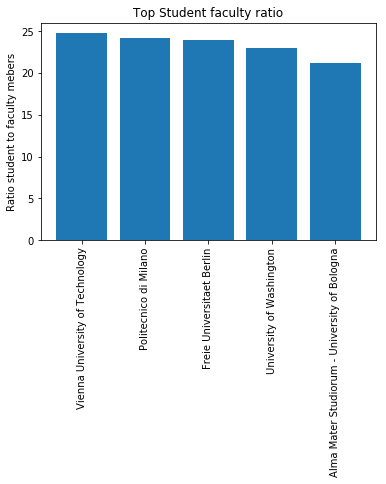

In [46]:
plotBarChart(df_with_ratio_tot.sort_values(by="ratio",ascending=False).head()["title"],\
             df_with_ratio_tot.sort_values(by="ratio",ascending=False).head()["ratio"],\
             'Top Student faculty ratio', 'Ratio student to faculty mebers')

In [19]:
df_with_ratio_inter = tu_df.join(df_ratio_inter)
df_with_ratio_inter.sort_values(by="ratio",ascending=False).head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio
34,United Kingdom,687.0,6748.0,35,Europe,London School of Economics and Political Scien...,1088.0,9760.0,0.691393
11,Switzerland,1300.0,5896.0,12,Europe,Ecole Polytechnique Fédérale de Lausanne (EPFL),1695.0,10343.0,0.570047
7,United Kingdom,2071.0,8746.0,8,Europe,Imperial College London,3930.0,16090.0,0.543567
198,Netherlands,502.0,8234.0,200,Europe,Maastricht University,1277.0,16385.0,0.502533
46,United States,425.0,6385.0,=47,North America,Carnegie Mellon University,1342.0,13356.0,0.478062


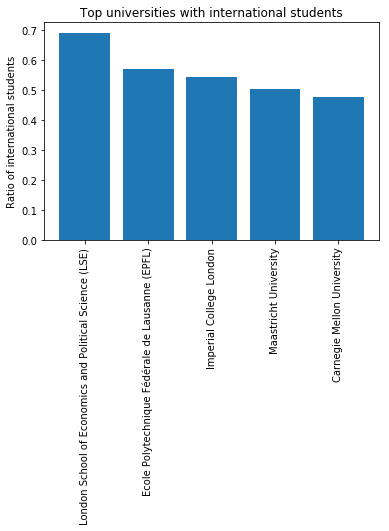

In [20]:
plotBarChart(df_with_ratio_inter.sort_values(by="ratio",ascending=False).head()["title"],\
             df_with_ratio_inter.sort_values(by="ratio",ascending=False).head()["ratio"],\
             'Top universities with international students', 'Ratio of international students')

- Answer the previous question aggregating the data by (c) country and (d) region.

In [21]:
df_with_ratio_tot.sort_values(["country","ratio"],ascending=False)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio
60,United States,550.0,8373.0,61,North America,University of Washington,2484.0,56973.0,22.935990
69,United States,75.0,4761.0,70,North America,Georgia Institute of Technology,1133.0,21082.0,18.607237
194,United States,206.0,4900.0,=195,North America,Texas A&M University,3446.0,60294.0,17.496808
66,United States,108.0,4744.0,67,North America,University of Texas at Austin,2833.0,47995.0,16.941405
164,United States,377.0,8538.0,=164,North America,"University of California, Irvine",1926.0,32151.0,16.693146
68,United States,259.0,9483.0,69,North America,University of Illinois at Urbana-Champaign,2554.0,42427.0,16.611981
133,United States,267.0,2128.0,134,North America,"University of California, Santa Barbara (UCSB)",1449.0,23149.0,15.975845
148,United States,653.0,7427.0,=149,North America,Michigan State University,2884.0,44951.0,15.586338
32,United States,662.0,6887.0,33,North America,"University of California, Los Angeles (UCLA)",2859.0,40114.0,14.030780
93,United States,211.0,7081.0,=93,North America,Pennsylvania State University,3509.0,45612.0,12.998575


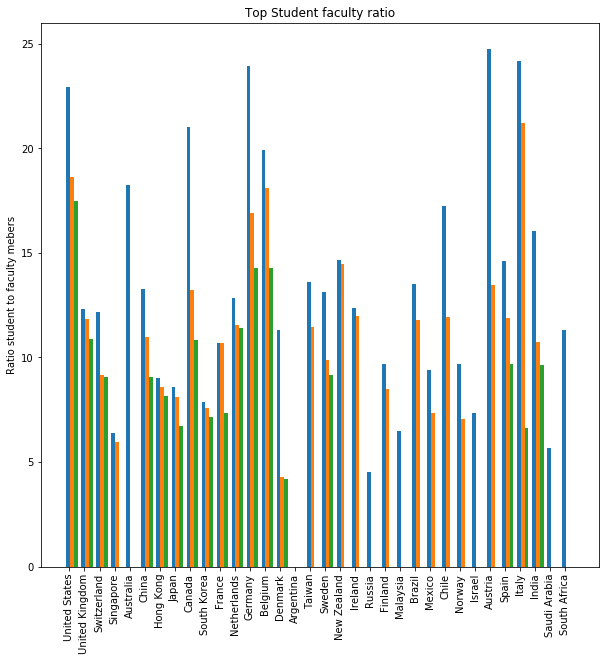

In [47]:
plotBarChartGroup(df_with_ratio_tot, "country", "ratio", 'Top Student faculty ratio', 'Ratio student to faculty mebers')

In [23]:
df_with_ratio_tot.sort_values(["region","ratio"],ascending=False)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio
175,Australia,546.0,7769.0,176,Oceania,University of Technology Sydney,1328.0,24207.0,18.228163
59,Australia,1679.0,20578.0,60,Oceania,Monash University,3204.0,57433.0,17.925406
150,New Zealand,759.0,3871.0,151,Oceania,University of Otago,1266.0,18532.0,14.638231
81,New Zealand,645.0,8568.0,=82,Oceania,The University of Auckland,2047.0,29641.0,14.480215
49,Australia,1829.0,17030.0,50,Oceania,The University of Sydney,3360.0,46678.0,13.892262
44,Australia,1612.0,14292.0,45,Oceania,The University of New South Wales (UNSW Sydney),2924.0,39784.0,13.606019
92,Australia,809.0,4575.0,=93,Oceania,The University of Western Australia,1420.0,18531.0,13.050000
41,Australia,1477.0,18030.0,=41,Oceania,The University of Melbourne,3311.0,42182.0,12.739958
108,Australia,633.0,8114.0,=109,Oceania,The University of Adelaide,1729.0,21240.0,12.284558
47,Australia,1870.0,10420.0,=47,Oceania,The University of Queensland,3158.0,37497.0,11.873654


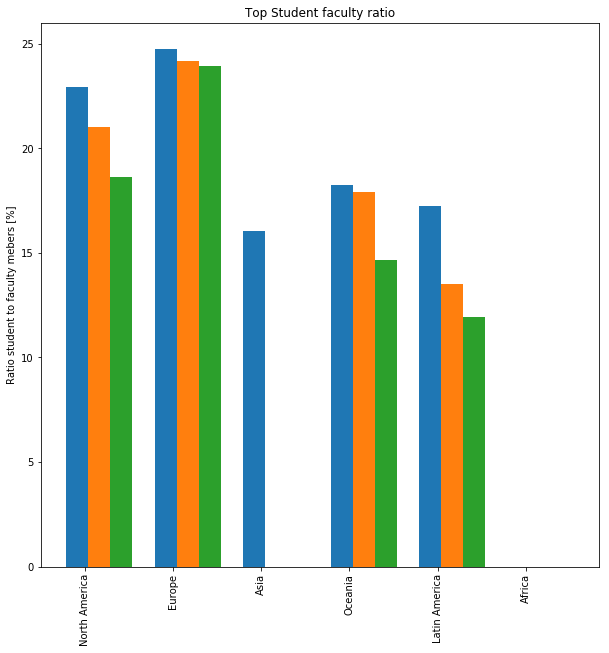

In [24]:
plotBarChartGroup(df_with_ratio_tot, "region", "ratio", 'Top Student faculty ratio', 'Ratio student to faculty mebers [%]')

In [25]:
df_with_ratio_inter.sort_values(["country","ratio"],ascending=False)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio
46,United States,425.0,6385.0,=47,North America,Carnegie Mellon University,1342.0,13356.0,0.478062
0,United States,1679.0,3717.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,11067.0,0.335863
17,United States,913.0,8105.0,18,North America,Columbia University,6189.0,25045.0,0.323617
185,United States,488.0,2805.0,186,North America,University of Rochester,2569.0,9636.0,0.291096
3,United States,350.0,647.0,4,North America,California Institute of Technology (Caltech),953.0,2255.0,0.286918
88,United States,316.0,1847.0,89,North America,Rice University,969.0,6610.0,0.279425
80,United States,379.0,7041.0,81,North America,Boston University,3157.0,25662.0,0.274375
164,United States,377.0,8538.0,=164,North America,"University of California, Irvine",1926.0,32151.0,0.265559
16,United States,1061.0,4105.0,17,North America,Johns Hopkins University,4462.0,16146.0,0.254243
8,United States,635.0,3379.0,9,North America,University of Chicago,2449.0,13557.0,0.249244


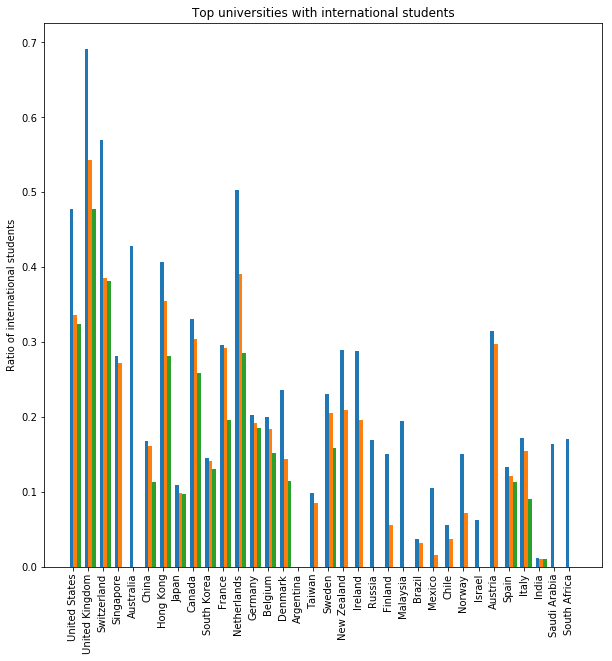

In [26]:
plotBarChartGroup(df_with_ratio_inter, "country", "ratio", 'Top universities with international students', 'Ratio of international students')

In [27]:
df_with_ratio_inter.sort_values(["region","ratio"],ascending=False)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio
41,Australia,1477.0,18030.0,=41,Oceania,The University of Melbourne,3311.0,42182.0,0.427434
19,Australia,927.0,5551.0,20,Oceania,The Australian National University,1600.0,14442.0,0.384365
108,Australia,633.0,8114.0,=109,Oceania,The University of Adelaide,1729.0,21240.0,0.382015
49,Australia,1829.0,17030.0,50,Oceania,The University of Sydney,3360.0,46678.0,0.364840
44,Australia,1612.0,14292.0,45,Oceania,The University of New South Wales (UNSW Sydney),2924.0,39784.0,0.359240
59,Australia,1679.0,20578.0,60,Oceania,Monash University,3204.0,57433.0,0.358296
175,Australia,546.0,7769.0,176,Oceania,University of Technology Sydney,1328.0,24207.0,0.320940
81,New Zealand,645.0,8568.0,=82,Oceania,The University of Auckland,2047.0,29641.0,0.289059
47,Australia,1870.0,10420.0,=47,Oceania,The University of Queensland,3158.0,37497.0,0.277889
92,Australia,809.0,4575.0,=93,Oceania,The University of Western Australia,1420.0,18531.0,0.246884


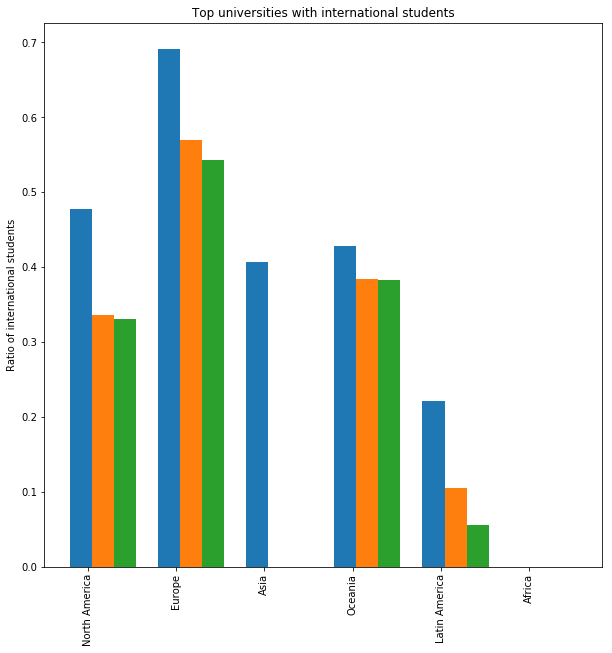

In [28]:
plotBarChartGroup(df_with_ratio_inter, "region", "ratio", 'Top universities with international students', 'Ratio of international students')

TODO bar charts and explanation

# Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). 

In [29]:
th_link = "https://www.timeshighereducation.com" 

In [30]:
req_th_ranking = requests.get(th_link+'/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
th_ranking = req_th_ranking.json()["data"]
th_ranking

[{'aliases': 'University of Oxford',
  'location': 'United Kingdom',
  'member_level': '0',
  'name': 'University of Oxford',
  'nid': 468,
  'rank': '1',
  'rank_order': '10',
  'record_type': 'master_account',
  'scores_citations': '99.1',
  'scores_citations_rank': '15',
  'scores_industry_income': '63.7',
  'scores_industry_income_rank': '169',
  'scores_international_outlook': '95.0',
  'scores_international_outlook_rank': '24',
  'scores_overall': '94.3',
  'scores_overall_rank': '10',
  'scores_research': '99.5',
  'scores_research_rank': '1',
  'scores_teaching': '86.7',
  'scores_teaching_rank': '5',
  'stats_female_male_ratio': '46 : 54',
  'stats_number_students': '20,409',
  'stats_pc_intl_students': '38%',
  'stats_student_staff_ratio': '11.2',
  'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineerin

In [31]:
len(th_ranking)

1102

In [32]:
ranks = []
for i in range(n):
    ranks.append(th_ranking[i]["rank"])
ranks

['1',
 '2',
 '=3',
 '=3',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=10',
 '=10',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '=22',
 '=22',
 '24',
 '=25',
 '=25',
 '=27',
 '=27',
 '=27',
 '30',
 '31',
 '32',
 '33',
 '=34',
 '=34',
 '36',
 '37',
 '=38',
 '=38',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '=50',
 '=50',
 '52',
 '53',
 '=54',
 '=54',
 '=56',
 '=56',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '=70',
 '=70',
 '=72',
 '=72',
 '=74',
 '=74',
 '76',
 '77',
 '78',
 '79',
 '=80',
 '=80',
 '82',
 '=83',
 '=83',
 '85',
 '=86',
 '=86',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '=95',
 '=95',
 '97',
 '98',
 '99',
 '=100',
 '=100',
 '=100',
 '103',
 '104',
 '=105',
 '=105',
 '107',
 '108',
 '=109',
 '=109',
 '=111',
 '=111',
 '=113',
 '=113',
 '115',
 '116',
 '=117',
 '=117',
 '=119',
 '=119',
 '121',
 '122',
 '=123',
 '=123',
 '125',
 '=126',
 '=126',
 '=126',
 '129',
 '=130',
 '=130',
 '1

In [33]:
# check equal ranks
print (th_ranking[2])
print (th_ranking[3])

# equal scores

{'rank_order': '30', 'rank': '=3', 'name': 'California Institute of Technology', 'scores_overall': '93.0', 'scores_overall_rank': '30', 'scores_teaching': '90.3', 'scores_teaching_rank': '1', 'scores_research': '97.5', 'scores_research_rank': '4', 'scores_citations': '99.5', 'scores_citations_rank': '10', 'scores_industry_income': '92.6', 'scores_industry_income_rank': '51', 'scores_international_outlook': '59.7', 'scores_international_outlook_rank': '322', 'record_type': 'private', 'member_level': '0', 'url': '/world-university-rankings/california-institute-technology', 'nid': 128779, 'location': 'United States', 'stats_number_students': '2,209', 'stats_student_staff_ratio': '6.5', 'stats_pc_intl_students': '27%', 'stats_female_male_ratio': '31 : 69', 'aliases': 'California Institute of Technology caltech', 'subjects_offered': 'Architecture,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Computer Science,Economics & Econometrics,Electrical & Electronic Enginee

In [34]:
th_ranking_200 = th_ranking[:n]

In [35]:
th_relevant_values = ["name", "aliases", "location", "rank", "stats_number_students", "stats_student_staff_ratio", "stats_pc_intl_students"]

th_ranking_filtered = []
for i in range(n):
    tmp_dict = {}
    for s in th_relevant_values:
        tmp_dict[s] = th_ranking_200[i][s]
    th_ranking_filtered.append(tmp_dict)
    
th_ranking_filtered

[{'aliases': 'University of Oxford',
  'location': 'United Kingdom',
  'name': 'University of Oxford',
  'rank': '1',
  'stats_number_students': '20,409',
  'stats_pc_intl_students': '38%',
  'stats_student_staff_ratio': '11.2'},
 {'aliases': 'University of Cambridge',
  'location': 'United Kingdom',
  'name': 'University of Cambridge',
  'rank': '2',
  'stats_number_students': '18,389',
  'stats_pc_intl_students': '35%',
  'stats_student_staff_ratio': '10.9'},
 {'aliases': 'California Institute of Technology caltech',
  'location': 'United States',
  'name': 'California Institute of Technology',
  'rank': '=3',
  'stats_number_students': '2,209',
  'stats_pc_intl_students': '27%',
  'stats_student_staff_ratio': '6.5'},
 {'aliases': 'Stanford University',
  'location': 'United States',
  'name': 'Stanford University',
  'rank': '=3',
  'stats_number_students': '15,845',
  'stats_pc_intl_students': '22%',
  'stats_student_staff_ratio': '7.5'},
 {'aliases': 'Massachusetts Institute of Te

In [36]:
th_df = pd.DataFrame.from_dict(th_ranking_filtered)
th_df.head()

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,University of Oxford,United Kingdom,University of Oxford,1,"20,409",38%,11.2
1,University of Cambridge,United Kingdom,University of Cambridge,2,"18,389",35%,10.9
2,California Institute of Technology caltech,United States,California Institute of Technology,=3,"2,209",27%,6.5
3,Stanford University,United States,Stanford University,=3,"15,845",22%,7.5
4,Massachusetts Institute of Technology,United States,Massachusetts Institute of Technology,5,"11,177",34%,8.7


In [37]:
th_df.stats_number_students = th_df.stats_number_students.apply(lambda x: ToNumeric(x))
tu_df.stats_number_students = th_df.stats_number_students.apply(pd.to_numeric)

th_df.stats_pc_intl_students = th_df.stats_pc_intl_students.apply(lambda x: ToNumeric(x))
th_df.stats_pc_intl_students = th_df.stats_pc_intl_students.apply(pd.to_numeric)

th_df.stats_student_staff_ratio = th_df.stats_student_staff_ratio.apply(lambda x: ToNumeric(x))
th_df.stats_student_staff_ratio = th_df.stats_student_staff_ratio.apply(pd.to_numeric)

Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [38]:
th_df.sort_values(by="stats_student_staff_ratio",ascending=False).head()

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
99,University of Bonn,Germany,University of Bonn,=100,35619,0.13,77.9
124,University of Mannheim,Germany,University of Mannheim,125,10995,0.16,74.5
91,Technical University of Berlin,Germany,Technical University of Berlin,92,22390,0.20,64.3
163,University of Erlangen-Nuremberg,Germany,University of Erlangen-Nuremberg,=162,38730,0.12,58.5
78,RWTH Aachen University,Germany,RWTH Aachen University,79,43721,0.18,57.7


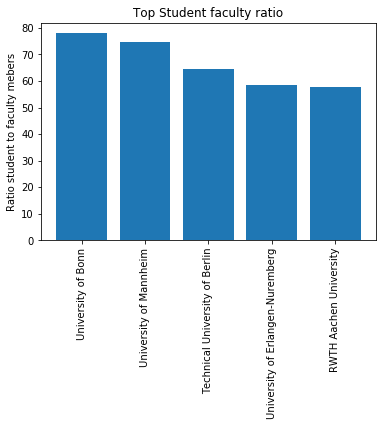

In [48]:
plotBarChart(th_df.sort_values(by="stats_student_staff_ratio",ascending=False).head()["name"],\
             th_df.sort_values(by="stats_student_staff_ratio",ascending=False).head()["stats_student_staff_ratio"],\
             'Top Student faculty ratio', 'Ratio student to faculty mebers')

In [40]:
th_df.sort_values(by="stats_pc_intl_students",ascending=False).head()

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
24,London School of Economics and Political Science,United Kingdom,London School of Economics and Political Science,=25,10065,0.71,12.2
178,University of Luxembourg,Luxembourg,University of Luxembourg,=179,4969,0.57,14.6
37,École Polytechnique Fédérale de Lausanne,Switzerland,École Polytechnique Fédérale de Lausanne,=38,9928,0.55,11.2
7,Imperial College London,United Kingdom,Imperial College London,8,15857,0.55,11.4
102,Maastricht University,Netherlands,Maastricht University,103,16727,0.50,18.0


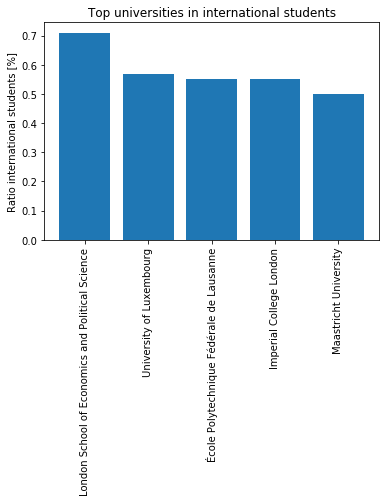

In [41]:
plotBarChart(th_df.sort_values(by="stats_pc_intl_students",ascending=False).head()["name"],\
             th_df.sort_values(by="stats_pc_intl_students",ascending=False).head()["stats_pc_intl_students"],\
             'Top universities in international students', 'Ratio international students [%]')

Answer the previous question aggregating the data by (c) country and (d) region.

In [42]:
th_df.sort_values(["location","stats_student_staff_ratio"],ascending=False)

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
52,"University of California, Santa Barbara",United States,"University of California, Santa Barbara",53,23054,0.14,28.1
159,Texas A&M University,United States,Texas A&M University,=159,56245,0.09,23.6
161,"University of California, Santa Cruz",United States,"University of California, Santa Cruz",=162,17866,0.04,23.0
36,University of Illinois at Urbana-Champaign,United States,University of Illinois at Urbana-Champaign,37,43402,0.23,22.8
32,Georgia Institute of Technology,United States,Georgia Institute of Technology,33,20773,0.27,20.7
197,"University of California, Riverside",United States,"University of California, Riverside",=198,20740,0.14,20.7
125,Arizona State University,United States,Arizona State University,=126,44475,0.19,20.1
142,University of Florida,United States,University of Florida,=143,46346,0.09,17.5
55,University of Minnesota,United States,University of Minnesota,=56,60949,0.11,17.4
59,Purdue University,United States,Purdue University,60,38770,0.23,17.4


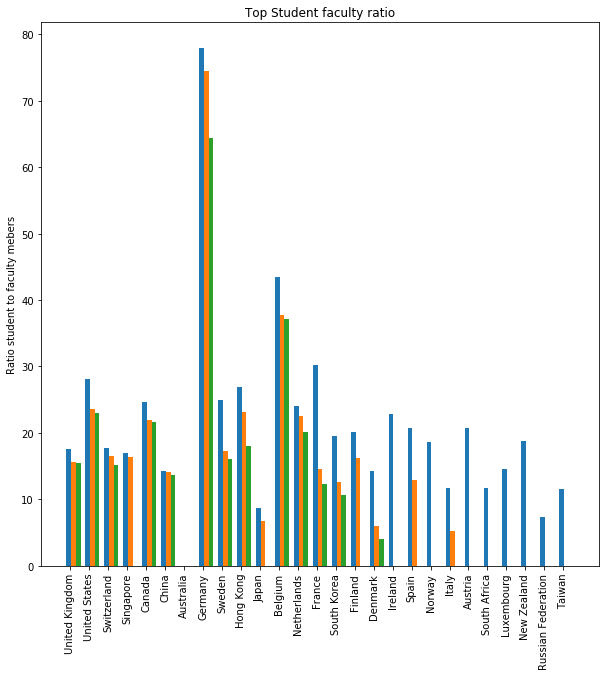

In [49]:
plotBarChartGroup(th_df, "location", "stats_student_staff_ratio", 'Top Student faculty ratio', 'Ratio student to faculty mebers')

In [44]:
th_df.sort_values(["location","stats_pc_intl_students"],ascending=False)

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
23,Carnegie Mellon University,United States,Carnegie Mellon University,24,12676,0.45,13.5
4,Massachusetts Institute of Technology,United States,Massachusetts Institute of Technology,5,11177,0.34,8.7
13,Columbia University,United States,Columbia University,14,26587,0.32,6.1
192,Northeastern University,United States,Northeastern University,193,18780,0.32,14.0
153,University of Rochester,United States,University of Rochester,=153,9636,0.29,4.3
85,Rice University,United States,Rice University,=86,6441,0.28,9.0
2,California Institute of Technology caltech,United States,California Institute of Technology,=3,2209,0.27,6.5
32,Georgia Institute of Technology,United States,Georgia Institute of Technology,33,20773,0.27,20.7
5,Harvard University,United States,Harvard University,6,20326,0.26,8.9
27,New York University,United States,New York University,=27,43860,0.26,9.6


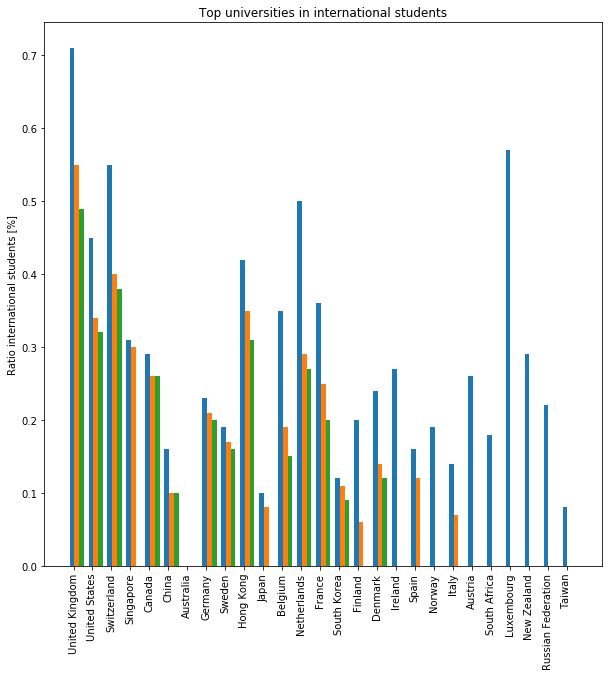

In [45]:
plotBarChartGroup(th_df, "location", "stats_pc_intl_students", 'Top universities in international students', 'Ratio international students [%]')

TODO description

# Merge Rankings